In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
# plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = 20, 13
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 2
import seaborn as sns

import sys
sys.path.insert(0, '../../..')
import assignment
import leximin_assignment
import matrix_gen
import kde_utils

from tqdm import tqdm

import warnings

In [2]:
def custom_eff_assignment(cost_matrix, capacities):
    full_cost_matrix = np.repeat(cost_matrix, capacities, axis=1)
    row_ind, col_ind = linear_sum_assignment(full_cost_matrix)
    
    return (
        col_ind // (cost_matrix.shape[0] // cost_matrix.shape[1]),
        full_cost_matrix[row_ind, col_ind].sum()
    )

In [3]:
df = pd.read_csv('../../../data/data.csv', index_col=0)
types = ['ES', 'TH', 'RRH', 'PREV']
df = df[df['Real'] != 2]
df = df.drop(labels='PSH', axis=1)

data = df[types].to_numpy().flatten()
kde = kde_utils.KDEHelper(np.log(data) - np.log(1 - data))

In [4]:
NS = [30, 40, 50, 60, 70, 80, 90, 100]
N_COLS = 5
N_EXPERIMENTS = 500

distrs = [
    np.random.uniform,
    np.random.beta,
    kde.sample_and_transform,
]
params = [(0, 1), (0.5, 0.5), (lambda x: 1 / (1 + np.exp(-x)), None)]
labels = ['U[0, 1]', 'Beta(0.5, 0.5)', 'KDE']

# Growth of upper bounds

In [10]:
r_u = [[[] for _ in NS] for __ in distrs]
r_n = [[[] for _ in NS] for __ in distrs]

for i in range(len(labels)):
    for n_i, n in enumerate(NS):
        print(labels[i], n)
        
        capacities = np.ones(N_COLS, dtype=int) * (n // N_COLS)
        matrix_generator = matrix_gen.MatrixGenerator(
            distrs[i], params[i], n, N_COLS
        )
        
        for _ in range(N_EXPERIMENTS):
            (_, sorted_matrix), (__, sorted_increase_matrix) = matrix_generator.get_increase_matrix_pair(
                round_=False
            )
            
            
            # L_u
            lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_matrix, capacities
            )
            lex_u_assignments = lex_u_assigner.solve()
            
            b_u = lex_u_assigner.get_cost_increases(
                lex_u_assignments, increase_matrix=sorted_matrix
            ).max()
            l_u = sorted_matrix[:, -1].min()
            
            r_u[i][n_i].append(b_u / l_u)
            
            # L_n
            lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_increase_matrix, capacities
            )
            lex_n_assignments = lex_n_assigner.solve()
            
            b_n = lex_n_assigner.get_cost_increases(
                lex_n_assignments, increase_matrix=sorted_increase_matrix
            ).max()
            # l_n = sorted_increase_matrix[:, -1].min()
            
            r_n[i][n_i].append(b_n / l_u)

U[0, 1] 30
U[0, 1] 40
U[0, 1] 50
U[0, 1] 60
U[0, 1] 70
U[0, 1] 80
U[0, 1] 90
U[0, 1] 100
Beta(0.5, 0.5) 30
Beta(0.5, 0.5) 40
Beta(0.5, 0.5) 50
Beta(0.5, 0.5) 60
Beta(0.5, 0.5) 70
Beta(0.5, 0.5) 80
Beta(0.5, 0.5) 90
Beta(0.5, 0.5) 100
KDE 30
KDE 40
KDE 50
KDE 60
KDE 70
KDE 80
KDE 90
KDE 100


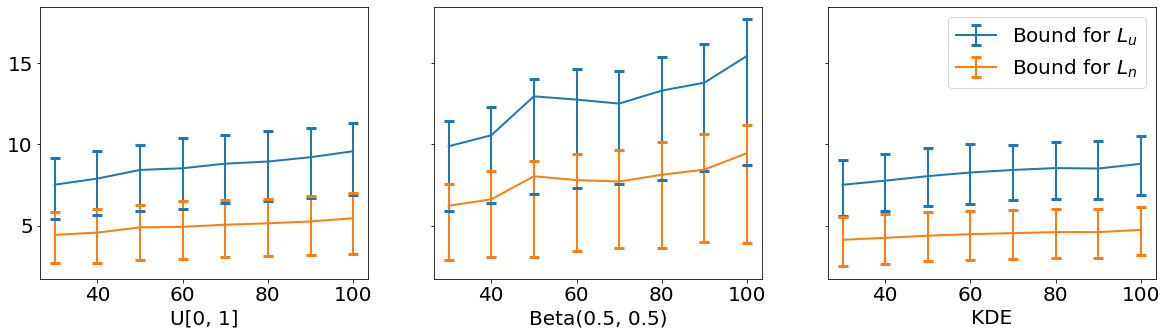

In [41]:
fig, ax = plt.subplots(1, len(labels), figsize=(20, 5), sharey=True)

for i in range(len(labels)):
    r_percnts = np.percentile(np.array(r_u[i]), [25, 75], axis=1)
    errors = r_percnts - np.array(r_u[i]).mean(axis=1)
    errors[0] *= -1
    errors = 1 + (N_COLS - 1) * errors
    ax[i].errorbar(
        NS, 1 + (N_COLS - 1) * np.array(r_u[i]).mean(axis=1),
        yerr=errors, label=r'Bound for $L_u$',
        capsize=5, capthick=3
    )
    
    r_percnts = np.percentile(np.array(r_n[i]), [25, 75], axis=1)
    errors = r_percnts - np.array(r_n[i]).mean(axis=1)
    errors[0] *= -1
    errors = 1 + (N_COLS - 1) * errors
    ax[i].errorbar(
        NS, 1 + (N_COLS - 2) * np.array(r_n[i]).mean(axis=1),
        yerr=errors, label=r'Bound for $L_n$',
        capsize=5, capthick=3
    )
    
    ax[i].set_xlabel(labels[i])

ax[-1].legend()
    
plt.show()

# Growth of PoF$(L_u)$ and POF$(L_n)$

In [5]:
pof_u = [[[] for _ in NS] for __ in distrs]
pof_n = [[[] for _ in NS] for __ in distrs]

pof_sorted_u = [[[] for _ in NS] for __ in distrs]
pof_sorted_n = [[[] for _ in NS] for __ in distrs]

for i in range(len(labels)):
    for n_i, n in enumerate(NS):
        print(labels[i], n)
        
        capacities = np.ones(N_COLS, dtype=int) * (n // N_COLS)
        matrix_generator = matrix_gen.MatrixGenerator(
            distrs[i], params[i], n, N_COLS
        )
        
        for _ in range(N_EXPERIMENTS):
            (
                (matrix, sorted_matrix),
                (increase_matrix, sorted_increase_matrix)
            ) = matrix_generator.get_increase_matrix_pair(round_=False)
            
            
            ### Original matrix
            # L_n
            lex_n_assigner = leximin_assignment.LeximinAssignmentHelperV3(
                increase_matrix * 1000, capacities
            )
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                lex_n_assignments = lex_n_assigner.solve(verbose=False)
            if lex_n_assignments is False:
                continue
            lex_n_cost = lex_n_assigner.get_cost(
                lex_n_assignments, cost_matrix=matrix
            )
            
            # L_u
            lex_u_assigner = leximin_assignment.LeximinAssignmentHelperV3(
                matrix * 1000, capacities
            )
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                lex_u_assignments = lex_u_assigner.solve(verbose=False)
            if lex_u_assignments is False:
                continue
            lex_u_cost = lex_u_assigner.get_cost(
                lex_u_assignments, cost_matrix=matrix
            )
            
            # Efficient
            eff_assignments, eff_cost = custom_eff_assignment(matrix, capacities)
            
            pof_u[i][n_i].append(lex_u_cost / eff_cost)
            pof_n[i][n_i].append(lex_n_cost / eff_cost)
            
            
            ### Increase (normalized) matrix
            # Efficient
            eff_assignments, eff_cost = custom_eff_assignment(sorted_matrix, capacities)
            
            # L_u
            lex_u_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_matrix, capacities
            )
            lex_u_assignments = lex_u_assigner.solve()
            lex_u_cost = lex_u_assigner.get_cost(
                lex_u_assignments, cost_matrix=sorted_matrix
            )
            
            pof_sorted_u[i][n_i].append(lex_u_cost / eff_cost)
            
            # L_n
            lex_n_assigner = leximin_assignment.RowSortedLeximinAssignmentHelper(
                sorted_increase_matrix, capacities
            )
            lex_n_assignments = lex_n_assigner.solve()
            lex_n_cost = lex_n_assigner.get_cost(
                lex_n_assignments, cost_matrix=sorted_matrix
            )
            
            pof_sorted_n[i][n_i].append(lex_n_cost / eff_cost)

U[0, 1] 30
U[0, 1] 40
U[0, 1] 50
U[0, 1] 60
U[0, 1] 70
U[0, 1] 80
U[0, 1] 90
U[0, 1] 100
Beta(0.5, 0.5) 30
Beta(0.5, 0.5) 40
Beta(0.5, 0.5) 50
Beta(0.5, 0.5) 60
Beta(0.5, 0.5) 70
Beta(0.5, 0.5) 80
Beta(0.5, 0.5) 90
Beta(0.5, 0.5) 100
KDE 30
KDE 40
KDE 50
KDE 60
KDE 70
KDE 80
KDE 90
KDE 100


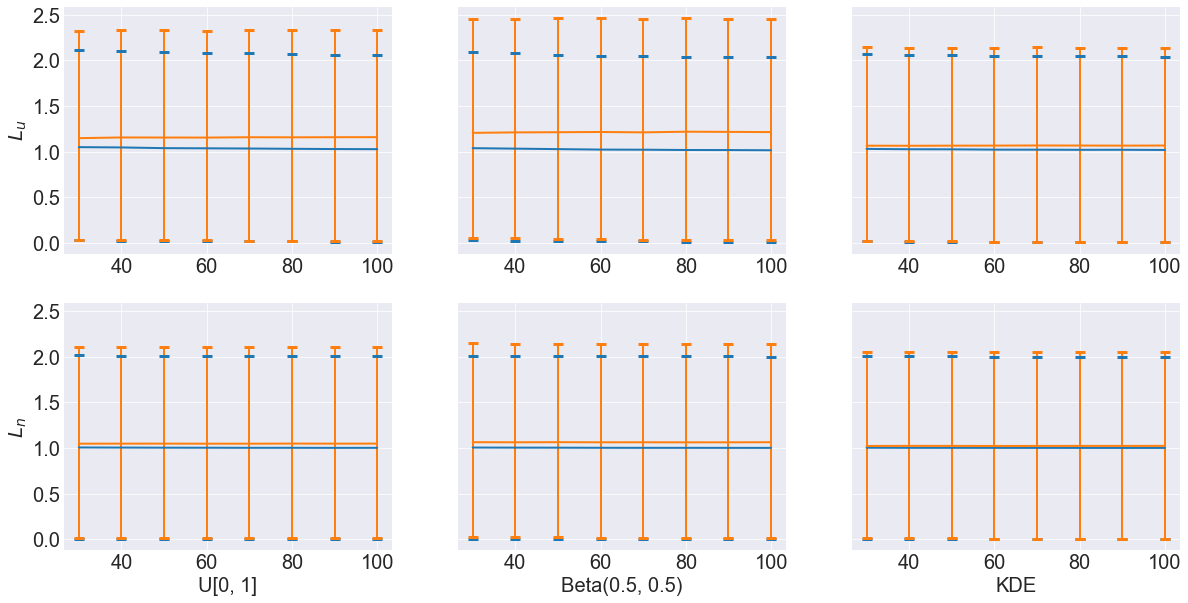

In [6]:
fig, ax = plt.subplots(2, len(labels), figsize=(20, 10), sharey=True)

for i in range(len(labels)):
    # PoF(L_u)
    errors = np.percentile(np.array(pof_u[i]), [25, 75], axis=1)
    ax[0][i].errorbar(
        NS, np.array(pof_u[i]).mean(axis=1),
        yerr=errors, label=r'Empirical PoF',
        capsize=5, capthick=3
    )
    
    errors = np.percentile(np.array(pof_sorted_u[i]), [25, 75], axis=1)
    ax[0][i].errorbar(
        NS, np.array(pof_sorted_u[i]).mean(axis=1),
        yerr=errors, label=r'Empirical PoF with sorted matrices',
        capsize=5, capthick=3
    )
    
    # PoF(L_n)
    errors = np.percentile(np.array(pof_n[i]), [25, 75], axis=1)
    ax[1][i].errorbar(
        NS, np.array(pof_n[i]).mean(axis=1),
        yerr=errors, label=r'Empirical PoF',
        capsize=5, capthick=3
    )
    
    errors = np.percentile(np.array(pof_sorted_n[i]), [25, 75], axis=1)
    ax[1][i].errorbar(
        NS, np.array(pof_sorted_n[i]).mean(axis=1),
        yerr=errors, label=r'Empirical PoF with sorted matrices',
        capsize=5, capthick=3
    )
    
    ax[1][i].set_xlabel(labels[i])

ax[0][0].set_ylabel(r'$L_u$')
# ax[0][0].legend()
ax[1][0].set_ylabel(r'$L_n$')
# ax[1][0].legend()
    
plt.show()

In [14]:
pof_lu_df

,PoF,N,Sorted rows
0,1.134756,30,False
1,1.041055,30,False
2,1.035095,30,False
3,1.077295,30,False
4,1.054326,30,False
...,...,...,...
23995,1.069180,100,True
23996,1.074574,100,True
23997,1.052454,100,True
23998,1.056827,100,True


In [12]:
percnts

array([[1.0208387 , 1.02178025, 1.01757726, 1.01830064, 1.01837225,
        1.01635729, 1.01475712, 1.01459274],
       [1.0668763 , 1.06218541, 1.04984299, 1.04776826, 1.04402777,
        1.04044158, 1.03595511, 1.03390102]])

In [13]:
means

array([1.04795974, 1.04475307, 1.03684594, 1.03510721, 1.03277266,
       1.0296878 , 1.02690425, 1.025522  ])

/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/quannguyen/anaconda3/envs/BayesFAI/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


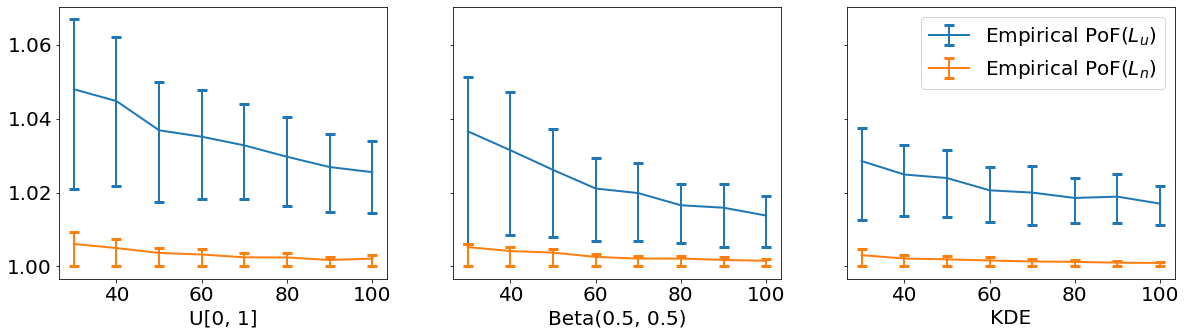

In [17]:
fig, ax = plt.subplots(1, len(labels), figsize=(20, 5), sharey=True)

for i in range(len(labels)):
    # PoF(L_u)
    grouped_pofs = pof_lu_df[~pof_lu_df['Sorted rows']][pof_lu_df['Distr'] == labels[i]].groupby('N')['PoF']
    percnts = grouped_pofs.quantile(q=[0.25, 0.75]).to_numpy().reshape(len(NS), 2).T
    means = grouped_pofs.mean().to_numpy()
    errors = percnts - means
    errors[0] *= -1
    ax[i].errorbar(
        NS, means,
        yerr=errors, label=r'Empirical PoF$(L_u)$',
        capsize=5, capthick=3
    )
    
    # PoF(L_n)
    grouped_pofs = pof_ln_df[~pof_ln_df['Sorted rows']][pof_ln_df['Distr'] == labels[i]].groupby('N')['PoF']
    percnts = grouped_pofs.quantile(q=[0.25, 0.75]).to_numpy().reshape(len(NS), 2).T
    means = grouped_pofs.mean().to_numpy()
    errors = percnts - means
    errors[0] *= -1
    ax[i].errorbar(
        NS, means,
        yerr=errors, label=r'Empirical PoF$(L_n)$',
        capsize=5, capthick=3
    )
    
    ax[i].set_xlabel(labels[i])


ax[-1].legend()
    
plt.show()

In [12]:
pof_lu_df = pd.DataFrame(columns=['PoF', 'N', 'Sorted rows'])

for i in range(len(labels)):
    for n_i, n in enumerate(NS):
        pof_lu_df = pd.concat([
            pof_lu_df,
            pd.DataFrame({
                'PoF': pof_u[i][n_i],
                'N': n,
                'Sorted rows': False
            }),
            pd.DataFrame({
                'PoF': pof_sorted_u[i][n_i],
                'N': n,
                'Sorted rows': True
            })
        ])

pof_lu_df.to_csv('pof_lu_df.csv', index=False)
pof_lu_df

,PoF,N,Sorted rows
0,1.134756,30,False
1,1.041055,30,False
2,1.035095,30,False
3,1.077295,30,False
4,1.054326,30,False
...,...,...,...
495,1.069180,100,True
496,1.074574,100,True
497,1.052454,100,True
498,1.056827,100,True


In [6]:
pof_lu_df = pd.read_csv('pof_lu_df_new.csv')
pof_lu_df

,PoF,N,Sorted rows,Distr
0,1.134756,30,False,"U[0, 1]"
1,1.041055,30,False,"U[0, 1]"
2,1.035095,30,False,"U[0, 1]"
3,1.077295,30,False,"U[0, 1]"
4,1.054326,30,False,"U[0, 1]"
...,...,...,...,...
23995,1.069180,100,True,KDE
23996,1.074574,100,True,KDE
23997,1.052454,100,True,KDE
23998,1.056827,100,True,KDE


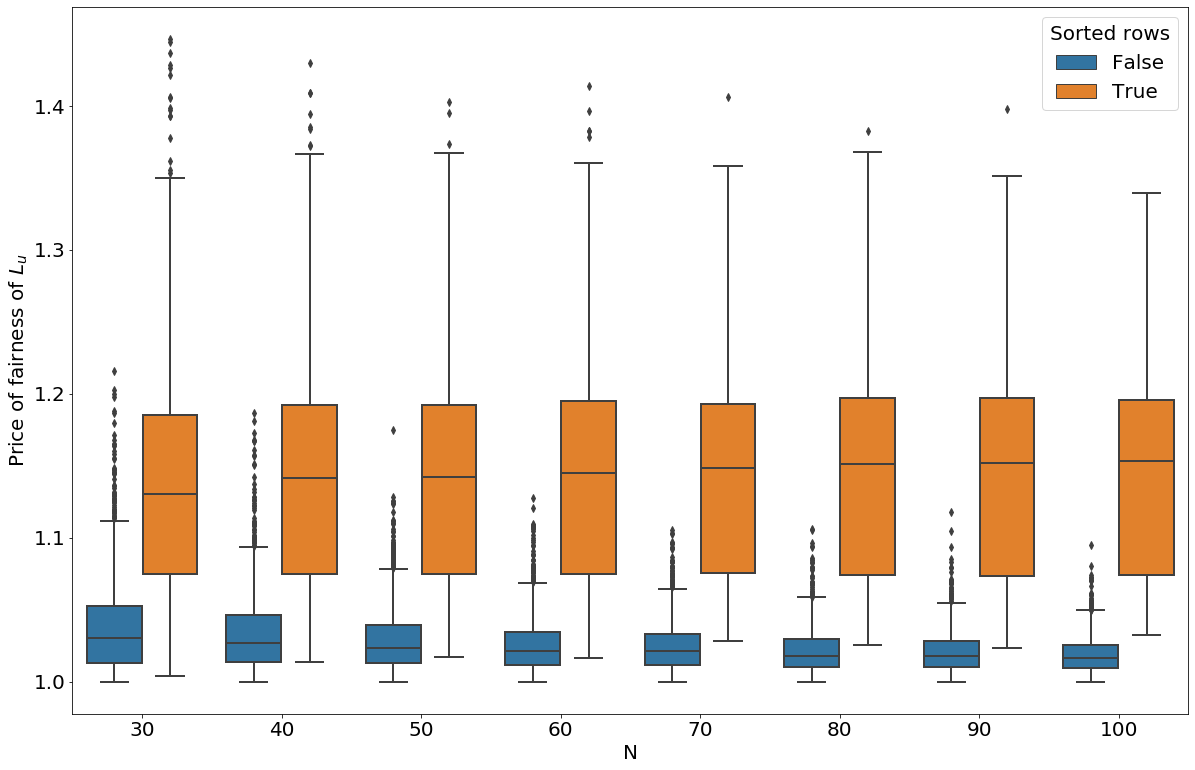

In [7]:
sns.boxplot(x='N', y='PoF', hue='Sorted rows', data=pof_lu_df)
plt.ylabel('Price of fairness of $L_u$')
plt.show()

In [7]:
pof_ln_df = pd.DataFrame(columns=['PoF', 'N', 'Sorted rows'])

for i in range(len(labels)):
    for n_i, n in enumerate(NS):
        pof_ln_df = pd.concat([
            pof_ln_df,
            pd.DataFrame({
                'PoF': pof_n[i][n_i],
                'N': n,
                'Sorted rows': False
            }),
            pd.DataFrame({
                'PoF': pof_sorted_n[i][n_i],
                'N': n,
                'Sorted rows': True
            })
        ])

pof_ln_df.to_csv('pof_ln_df.csv', index=False)
pof_ln_df

NameError: name 'pof_n' is not defined

In [8]:
pof_ln_df = pd.read_csv('pof_ln_df_new.csv')
pof_ln_df

,PoF,N,Sorted rows,Distr
0,1.008203,30,False,"U[0, 1]"
1,1.000000,30,False,"U[0, 1]"
2,1.013819,30,False,"U[0, 1]"
3,1.000219,30,False,"U[0, 1]"
4,1.000000,30,False,"U[0, 1]"
...,...,...,...,...
23995,1.030306,100,True,KDE
23996,1.025852,100,True,KDE
23997,1.017923,100,True,KDE
23998,1.022341,100,True,KDE


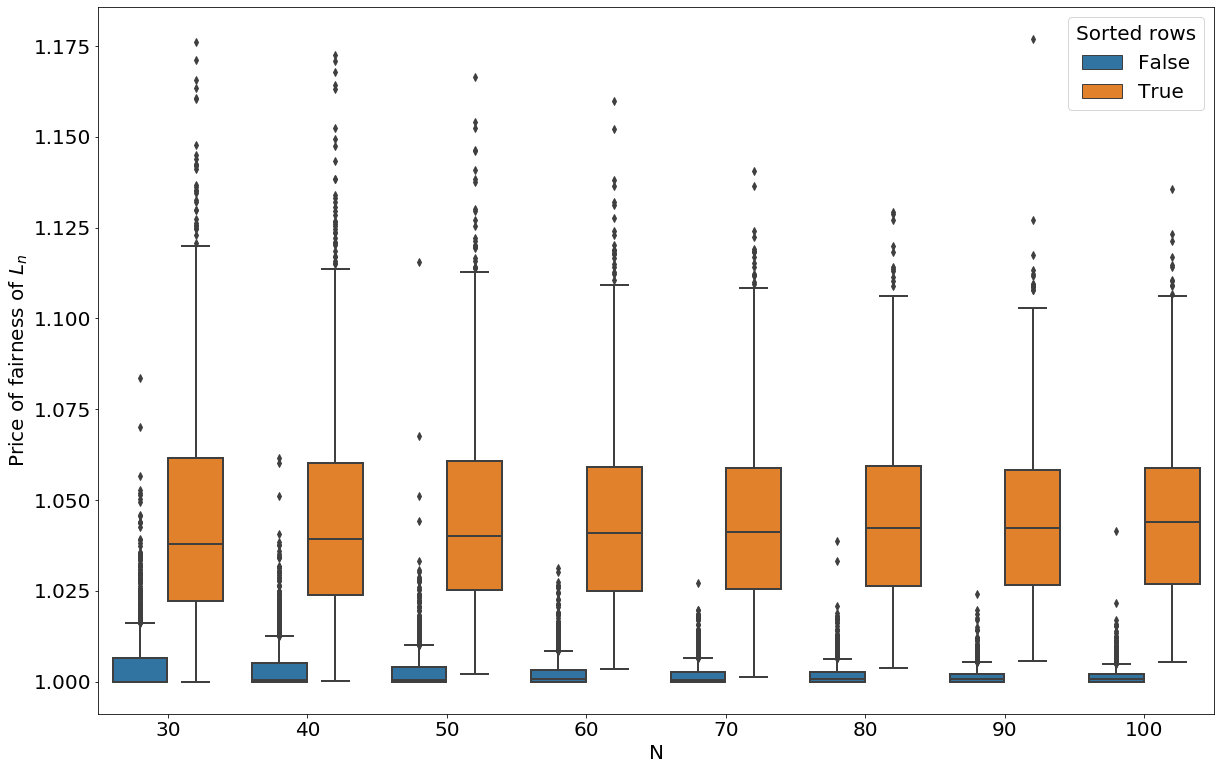

In [9]:
sns.boxplot(x='N', y='PoF', hue='Sorted rows', data=pof_ln_df)
plt.ylabel('Price of fairness of $L_n$')
plt.show()